In [1]:
#Import Necessary Libraries
from matplotlib.pyplot import *
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from statistics import mode

In [2]:
class LIF:
    def __init__(self, i_func, time_interval=100, dt=0.125, u_rest=0, R=1, 
                 C=10, threshold=5, neuron_type='excitatory'):
        self.time_interval = time_interval
        self.dt = dt
        self.i_func = i_func
        self.u_rest = u_rest
        self.R = R
        self.C = C
        self.threshold = threshold
        self.u = []
        self.i_init = []
        self.timer = []
        self.cur_time = 0
        self.is_spiked = False
        self.type = neuron_type
        self.last_spike = -1
        
     #init u values
    def start(self):
        self.timer = np.arange(0, self.time_interval + self.dt, self.dt)
        u = [self.u_rest for i in range(len(self.timer))]
        self.i_init = [self.i_func(j) for j in self.timer]
        
        const = self.R * self.C
        for t in range(len(self.timer)):
            self.is_spiked = False
            self.cur_time = t
            u[t] = u[t-1] + (((-u[t-1] + self.u_rest) + self.R * self.i_init[t]) * self.dt)/const
            self.u = u
            #checking for action potential
            if u[t] >= self.threshold or u[t] < self.u_rest:
                u[t] = self.u_rest
                self.is_spiked = True
                self.u = u
                self.last_spike = self.cur_time * self.dt
            yield self.is_spiked
            
        
        
     #draw desire plot (u-t/i-t/f-i)   
    def draw_plot(self, plot_name='u-t'):
        
        fig = figure(num=None, figsize=(20, 10))
        fig.suptitle('Leaky Integrate and Fire\n\n\n' +
                     "R: " + str(self.R) +
                     "    C: " + str(self.C) +
                     "    I: " + (str(self.i_func.__doc__).strip()) +
                     "    THRESHOLD: " + str(self.threshold) + 
                     '\n\n', fontsize=14, fontweight='bold')
        
        #checking for desire plots that want to draw it.
        if plot_name == 'u-t':
            subplot(221)
            plot(self.timer, self.u)
            ylabel('U')
            xlabel('Time')
            title('U - Time plot')
            grid(True)
            
        if plot_name == 'i-t':
            subplot(221)
            plot(self.timer, self.i_init)
            ylabel('I')
            xlabel('Time')
            title('I - Time plot')
            grid(True)
        
        
    def period_of_time(self, i_const=0):
        time_periods = []
        const = self.R * self.C
        u = [self.u_rest for i in range(len(self.timer))]
        curr = Current(c=i_const)
        i_const = curr.i_constant(self.time_interval)
        prev_period = 0
        for t in range(len(self.timer)):
            u[t] = u[t-1] + (((-u[t-1] + self.u_rest) + self.R * i_const) * self.dt)/const
            if u[t] >= self.threshold :
                u[t] = self.u_rest
                time_periods.append(self.timer[t] - prev_period)
                prev_period = self.timer[t]       
        return mode(time_periods)        
            
        
    def draw_F_I_plot(self):
        
        fig = figure(num=None, figsize=(20, 10))
        fig.suptitle('Leaky Integrate and Fire\n\n\n' +
                     "R: " + str(self.R) +
                     "    C: " + str(self.C) +
                     "    I: " + (str(self.i_func.__doc__).strip()) +
                     "    THRESHOLD: " + str(self.threshold) + 
                     '\n\n', fontsize=14, fontweight='bold')   
        
        
        const = self.R * self.C
        i_x = np.arange(0, max(self.i_init), self.dt)
        i_y = [0 for _ in range(len(i_x))]
            
        #set y values in (try/catch) block for div by zero exception
        for j in range(len(i_x)):
            try:
                i_y[j] = 1 / (self.period_of_time(i_const=i_x[j]))
            except:
                i_y[j] = 0
                          
        subplot(221)
        plot(i_x, i_y)
        ylabel('F')
        xlabel('I')
        title('F - I plot')
        grid(True) 

In [3]:
class NeuronsGroup:

  def __init__(self, neurons, connections, w_table, excitatory_delay=1,
               inhibitory_delay=1, iteration_count=800):
    self.neurons = neurons
    self.neroun_action = []
    for i in neurons:
      self.neroun_action.append(i.start())
    
    self.w_table = w_table
    self.connections = connections
    self.iteration_count = iteration_count
    self.spikes = []
    self.excitatory_spikes_time = []
    self.excitatory_spikes = []
    self.inhibitory_spikes_time = []
    self.inhibitory_spikes = []
    self.excitatory_delay = excitatory_delay
    self.inhibitory_delay = inhibitory_delay
    self.spikes_effect = []

  def start(self):
    self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.iteration_count)]
    for t in range(self.iteration_count):
    
      for i in range(len(self.neroun_action)):

        action_info = next(self.neroun_action[i])
        if action_info == True :
          
          for j in self.connections[i]:
            if self.neurons[i].type == 'excitatory':
              self.excitatory_spikes.append(i + 1)
              self.excitatory_spikes_time.append(t)
              if t+self.excitatory_delay < self.iteration_count:
                self.spikes_effect[t + self.excitatory_delay][j] += self.w_table[i][j]

            if self.neurons[i].type == 'inhibitory':
              self.inhibitory_spikes.append(i + 1)
              self.inhibitory_spikes_time.append(t)
              if t+self.inhibitory_delay < self.iteration_count:
                self.spikes_effect[t+self.inhibitory_delay][j] -= self.w_table[i][j]
      for i in range(len(self.neurons)):
        self.neurons[i].u[self.neurons[i].cur_time] += self.spikes_effect[t][i]
      yield True
    yield False
      

  def neurons_u_plot(self, neurons_count=5):
    legend = []
    for i in range(min(neurons_count, len(self.neurons))):
      plt.plot(list(map(lambda j: j * self.neurons[i].dt, range(len(self.neurons[i].u)))), self.neurons[i].u)
      legend.append('neuron ' + str(i+1))
    plt.legend(legend)

  def raster_plot(self):
    plt.scatter(self.excitatory_spikes_time, self.excitatory_spikes, color='blue', s=10)
    plt.scatter(self.inhibitory_spikes_time, self.inhibitory_spikes, color='red', s=10)
    plt.legend(['excitatory', 'inhibitory'])

In [4]:
class stdp:
    def __init__(self, neurons_group, a_plus, a_neg, d_tau_pos, d_tau_neg):
        self.gp = neurons_group
        self.a_plus = a_plus
        self.a_neg = a_neg
        self.dt_pos = d_tau_pos
        self.dt_neg = d_tau_neg
        
        self.w_his = []
        
    def train(self):
        nex = self.gp.start()
        while next(nex):
            temp = []
            for t1 in self.gp.w_table:
                temp2 = []
                for w in t1:
                    temp2.append(w)
                temp.append(temp2)
            self.w_his.append(temp)
            
            for i in range(len(self.gp.neurons)):
                for j in self.gp.connections[i]:
                    dt = self.gp.neurons[j].last_spike - self.gp.neurons[i].last_spike
                    stdp_val = 0
                    if dt > 0:
                        stdp_val = self.a_plus * math.exp(math.fabs(dt)/self.dt_pos)
                    elif dt < 0:
                        stdp_val = self.a_neg * math.exp(math.fabs(dt)/self.dt_neg)
                    self.gp.w_table[i][j] += stdp_val
                    
                    if self.gp.w_table[i][j] <= 0:
                        self.gp.w_table[i][j] = 0
    def w_plot(self, i, j):
        w_t = []
        for t in self.w_his:
            w_t.append(t[i][j])
        plt.plot(list(map(lambda x: x * self.gp.neurons[i].dt, range(len((w_t))))), w_t)
                        

In [5]:
func = lambda x: 2000 * (math.sin(x) + 0.01)

In [6]:
n1 = LIF(i_func=func)
n2 = LIF(i_func=func)
n3 = LIF(i_func=func)


In [7]:
connections = [[1, 2], [0, 2], [0, 1]]

In [8]:
nurons = [n1, n2, n3]

In [9]:
weight_table = []

In [10]:
for i in range(3):
    t = []
    for j in range(3):
        t.append(random.randint(1, 4))
        if i == j:
            t[j] = 0
    weight_table.append(t)
print(weight_table)

[[0, 1, 1], [4, 0, 1], [2, 3, 0]]


In [11]:
gp = NeuronsGroup(nurons, connections, weight_table)

In [12]:
learnin = stdp(gp, 2, -3, 0.3, 0.4)

In [13]:
learnin.train()

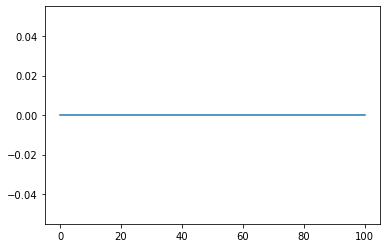

In [14]:
learnin.w_plot(2 ,2)

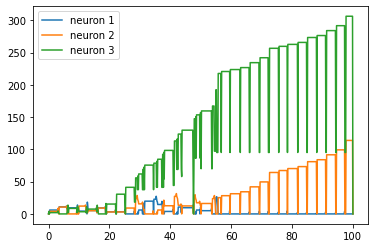

In [15]:
gp.neurons_u_plot()

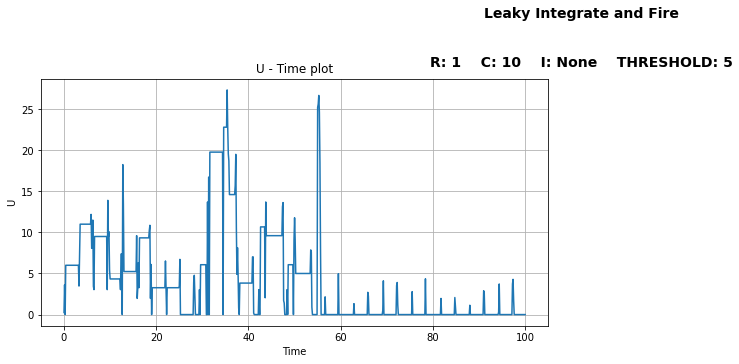

In [16]:
n1.draw_plot()

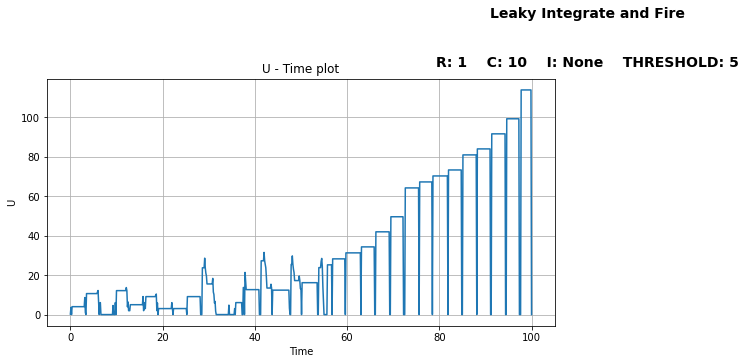

In [17]:
n2.draw_plot()

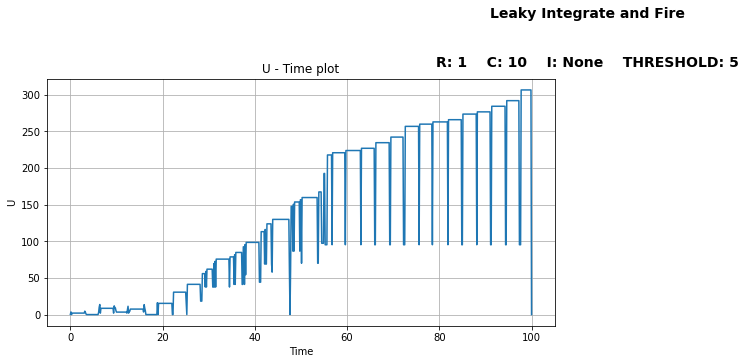

In [18]:
n3.draw_plot()

In [19]:
print(weight_table)

[[0, 113.85355599164275, 211.05054469679254], [0, 0, 95.18770959476768], [0, 0, 0]]
